In [1]:
import cftime
from datetime import timedelta
from datetime import datetime
import glob
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy import signal

import mission_tools

%matplotlib widget

In [2]:
# Load the mission Dataframe and plot against other characteristics
mission_df = pd.read_csv('../../microSWIFT_data/mission_df.csv')
mission_df_sorted = mission_df.sort_values(by=['mission number'])
mission_df_sorted

,Unnamed: 0,time,mission number,Hs [m],Tm [s],Mean Dir [deg],cross shore gamma location [m],break depth,freq [hz],energy density [m^2\hz],direction bins [deg],directional energy density [m^2/hz/deg],wind speed [m/s],wind direction [deg],water level [m]
49,49,2021-10-04 15:08:29.997960,1,0.528284,10.316686,84.508421,184.648276,1.509383,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.006250970927468175, 0.008517361007810514, 0...","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[8.747556421440095e-06, 8.959506885730661e-06...",3.497996,242.846450,-0.471
34,34,2021-10-05 14:45:59.999040,2,0.530041,8.468174,87.800275,185.176807,1.514404,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.008210807393248865, 0.009606624313353596, 0...","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[1.5127389815461356e-05, 1.537798198114615e-0...",4.733083,201.046620,-0.126
15,15,2021-10-05 17:26:59.997600,3,0.528707,8.890307,84.376313,184.775430,1.510591,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.0074744052512894605, 0.0092713770151894, 0....","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[1.0573883628239855e-05, 1.1059385542466771e-...",3.082500,119.145035,-0.569
64,64,2021-10-05 18:18:29.998680,4,0.522822,8.807460,84.789797,183.005448,1.493776,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.008461591649143705, 0.009608970959136827, 0...","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[1.2740909369313158e-05, 1.4296941117208917e-...",3.584333,131.287700,-0.479
45,45,2021-10-05 18:44:59.998800,5,0.536204,8.799833,84.839580,187.030309,1.532012,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.008366571810877113, 0.010221537206923438, 0...","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[1.2165210137027316e-05, 1.297256130783353e-0...",4.637333,141.048070,-0.415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,31,2021-10-29 14:05:29.999340,77,2.115383,6.881350,80.618171,527.467029,6.043950,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.0561112684943642, 0.07520820486194499, 0.37...","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[0.0001238615222973749, 0.000127437015180476,...",11.580667,142.345210,0.469
0,0,2021-10-29 14:33:54.998780,78,2.133724,6.918120,80.728183,532.012197,6.096354,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.05025098354559162, 0.07217063888585135, 0.3...","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[8.774435264058411e-05, 9.57169831963256e-05,...",9.615158,156.119450,0.499
10,10,2021-10-29 15:07:59.999160,79,2.146968,6.969036,81.012755,535.297751,6.134193,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.047821868763719966, 0.07050237658456894, 0....","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[8.774435264058411e-05, 9.57169831963256e-05,...",11.160000,150.033300,0.586
35,35,2021-10-29 15:29:14.999220,80,2.137428,7.014631,81.500423,532.931204,6.106938,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.05565776644537009, 0.07347708404976316, 0.3...","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[8.774435264058411e-05, 9.57169831963256e-05,...",10.380000,153.091420,0.680


In [90]:
def extract_jump_inds(jump_inds, consecutive_values=1):
    event_inds = np.where(jump_inds == 1)[0]
    event_groups = np.split(event_inds, np.where(np.diff(event_inds) != consecutive_values)[0]+1)
    return event_groups

mission_list = glob.glob('../../microSWIFT_data/final_dataset/mission_*.nc')

mission_number = []
jump_amps_all_missions = []
jump_seconds_all_missions = []
jump_depth_all_missions = []
mission_number_for_event = []
trajectory_number_for_event = []

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
    y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])
    time = cftime.num2pydate(mission_dataset['time'],
                                units=mission_dataset['time'].units,
                                calendar=mission_dataset['time'].calendar)

    number_of_trajectories = x_locations.shape[0]

    mission_num = int(mission_nc[44:-3])
    mission_number.append(mission_num)
    # Add mean water level 
    water_level = mission_df_sorted[mission_df_sorted['mission number'] == mission_num]['water level [m]'].values[0]
    jump_amps_each_mission = []
    jump_seconds_each_mission = []
    jump_depth_each_mission = []

    for trajectory_num in np.arange(number_of_trajectories):

        # Compute Cross Shore Velocity from Cross Shore Position
        cross_shore_vel = np.gradient((x_locations[trajectory_num,0] - x_locations[trajectory_num,:]), 1/12)
        cross_shore_vel = np.ma.filled(cross_shore_vel, np.NaN)
        sos = signal.butter(1, 0.1, 'lowpass', fs=12, output='sos')
        cross_shore_vel_filtered = signal.sosfilt(sos, cross_shore_vel)

        # Depth Along Trajectory
        trajectory_bathy = mission_tools.bathy_along_track(bathy_file='../../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc', 
                                                            xFRF=x_locations[trajectory_num, :], 
                                                            yFRF=y_locations[trajectory_num, :],
                                                            single_trajectory=True)[0]
        trajectory_depth = trajectory_bathy + water_level

        # Compute Linear Phase Speed at each point in track
        phase_speed_along_track = np.sqrt(np.abs(trajectory_depth * 9.8))

        # Find all times that the cross shore velocity is higher than the threshold
        jump_threshold = phase_speed_along_track * 0.3
        jump_times = np.zeros(cross_shore_vel_filtered.size)
        jump_inds = np.where(cross_shore_vel_filtered > jump_threshold)
        jump_times[jump_inds] = 1

        # Compute Cross Shore Distance Traveled
        dist_traveled = x_locations[trajectory_num,0] - x_locations[trajectory_num,:]

        # Get the jump Indices
        jump_event_inds = extract_jump_inds(jump_times, consecutive_values=1)

        for event in jump_event_inds:
            if event.size > 0:
                jump_amps_each_mission.append(dist_traveled[event[-1]] - dist_traveled[event[0]])
                jump_seconds_each_mission.append((time[event[-1]] - time[event[0]]).total_seconds())
                jump_depth_each_mission.append(np.abs(np.mean([trajectory_depth[event[0]], trajectory_depth[event[-1]]])))
                mission_number_for_event.append(mission_num)
                trajectory_number_for_event.append(trajectory_num)
    
    # save each mission
    jump_amps_all_missions.append(jump_amps_each_mission)
    jump_seconds_all_missions.append(jump_seconds_each_mission)
    jump_depth_all_missions.append(jump_depth_each_mission)

# flatten and concatenate each distribution
jump_amps_all_missions_flat = np.ma.concatenate(jump_amps_all_missions).flatten()
jump_seconds_all_missions_flat = np.ma.concatenate(jump_seconds_all_missions).flatten()
jump_depth_all_missions_flat = np.ma.concatenate(jump_depth_all_missions).flatten()

(0.0, 0.3)

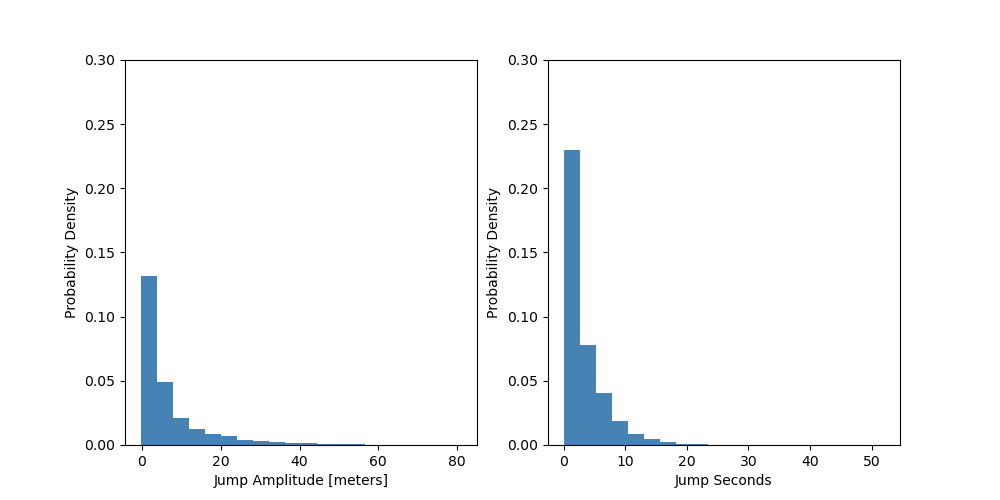

In [4]:
# Plot Histrograms of the jump events from the whole mission
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

# jump amplitudes
ax1.hist(jump_amps_all_missions_flat, bins=20, density=True, color='steelblue')
ax1.set_xlabel('Jump Amplitude [meters]')
ax1.set_ylabel('Probability Density')
ax1.set_ylim(0, 0.3)

# jump size
ax2.hist(jump_seconds_all_missions_flat, bins=20, density=True, color='steelblue')
ax2.set_xlabel('Jump Seconds')
ax2.set_ylabel('Probability Density')
ax2.set_ylim(0, 0.3)

In [5]:
# Compute Mean and std Jump Amplitude and Time for each mission
jump_amps_mean = []
jump_amps_std = []
jump_seconds_mean = []
jump_seconds_std = []

for n in np.arange(len(jump_amps_all_missions)):
    # Amplitude
    jump_amps_mean.append(np.mean(jump_amps_all_missions[n]))
    jump_amps_std.append(np.std(jump_amps_all_missions[n]))

    # Time
    jump_seconds_mean.append(np.mean(jump_seconds_all_missions[n]))
    jump_seconds_std.append(np.std(jump_seconds_all_missions[n]))

# Sort the missions in ascending order
sort_inds = np.argsort(mission_number)
mission_num_sorted = np.array(mission_number)[sort_inds]
jump_amps_mean_sorted = np.array(jump_amps_mean)[sort_inds]
jump_amps_std_sorted = np.array(jump_amps_std)[sort_inds]
jump_seconds_mean_sorted = np.array(jump_seconds_mean)[sort_inds]
jump_seconds_std_sorted = np.array(jump_seconds_std)[sort_inds]


/opt/homebrew/Caskroom/mambaforge/base/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/mambaforge/base/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/mambaforge/base/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/Caskroom/mambaforge/base/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/homebrew/Caskroom/mambaforge/base/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encoun

Text(0, 0.5, 'Average Jump Amplitude [m]')

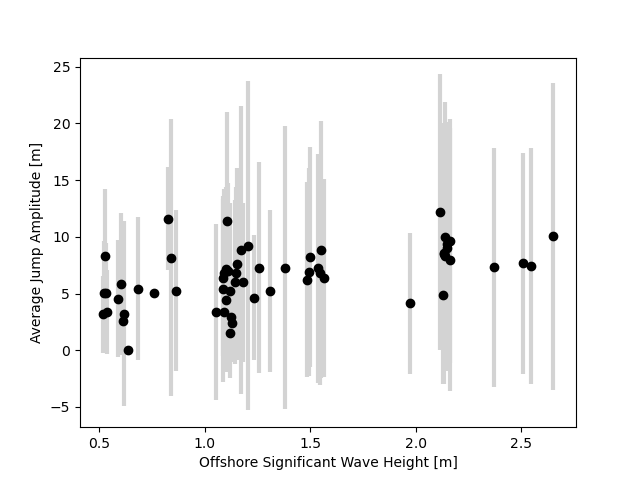

In [6]:
# Scatter the average jump amplitude and the significant wave height
fig, ax = plt.subplots()
ax.scatter(mission_df_sorted['Hs [m]'].values, jump_amps_mean_sorted, color='k')
ax.errorbar(x=mission_df_sorted['Hs [m]'].values, y=jump_amps_mean_sorted, 
            yerr=jump_amps_std_sorted, fmt='none', marker=None,
            ecolor='lightgray', elinewidth=3, capsize=0, zorder=0)
ax.set_xlabel('Offshore Significant Wave Height [m]')
ax.set_ylabel('Average Jump Amplitude [m]')


Text(0, 0.5, 'Average Jump Time [seconds]')

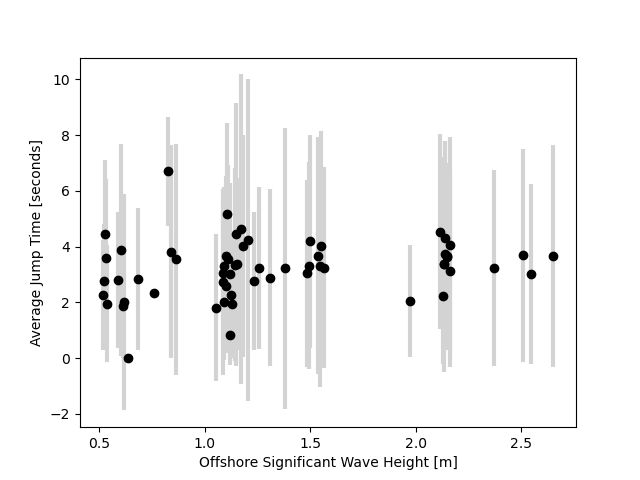

In [7]:
# Scatter the average jump amplitude and the significant wave height
fig, ax = plt.subplots()
ax.scatter(mission_df_sorted['Hs [m]'].values, jump_seconds_mean_sorted, color='k')
ax.errorbar(x=mission_df_sorted['Hs [m]'].values, y=jump_seconds_mean_sorted, 
            yerr=jump_seconds_std_sorted, fmt='none', marker=None,
            ecolor='lightgray', elinewidth=3, capsize=0, zorder=0)
ax.set_xlabel('Offshore Significant Wave Height [m]')
ax.set_ylabel('Average Jump Time [seconds]')

Text(0, 0.5, 'Jump Amplitude [m]')

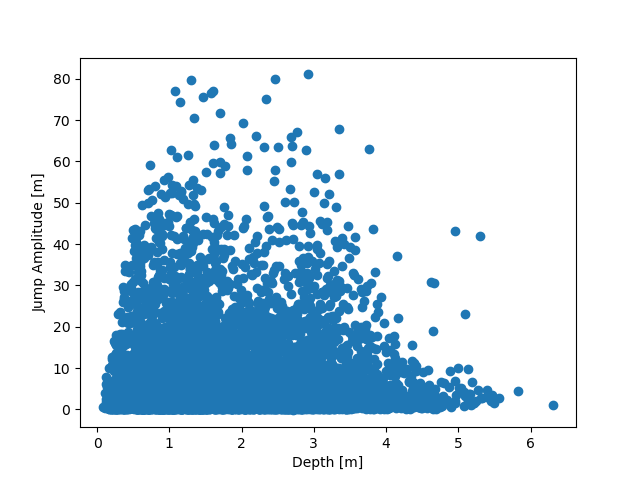

In [8]:
# Scatter Jump Amplitude and Depth
fig, ax = plt.subplots()
ax.scatter(jump_depth_all_missions_flat, jump_amps_all_missions_flat)
ax.set_xlabel('Depth [m]')
ax.set_ylabel('Jump Amplitude [m]')

Text(0, 0.5, 'Jump Seconds')

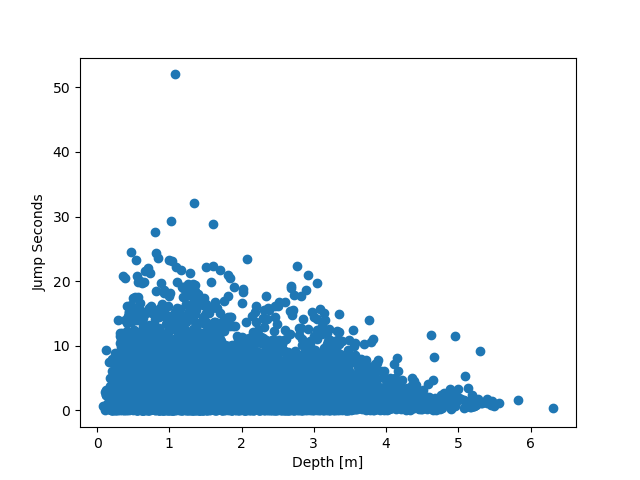

In [9]:
# Scatter Jump Amplitude and Depth
fig, ax = plt.subplots()
ax.scatter(jump_depth_all_missions_flat, jump_seconds_all_missions_flat)
ax.set_xlabel('Depth [m]')
ax.set_ylabel('Jump Seconds')

19


Text(0, 0.5, 'Jump Amplitude [m]')

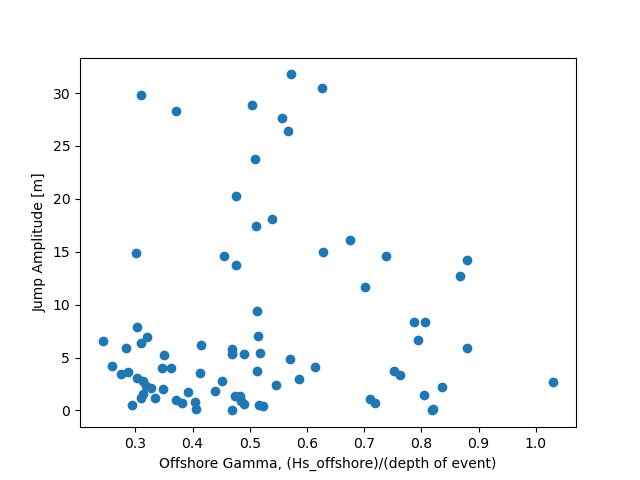

In [19]:
# Look at Jump Amplitudes as a function of depth for mission 19
n = 6
print(mission_number[n])
fig, ax = plt.subplots()
hs = mission_df_sorted[mission_df_sorted['mission number'] == 19]['Hs [m]'].values[0]
ax.scatter(hs/jump_depth_all_missions[n], jump_amps_all_missions[n])
ax.set_xlabel('Offshore Gamma, (Hs_offshore)/(depth of event)')
ax.set_ylabel('Jump Amplitude [m]')


/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_35573/1701270385.py:7: RuntimeWarning: divide by zero encountered in divide
  offshore_gamma_all_missions.append(hs/jump_amps_all_missions[n])


Text(0, 0.5, 'Jump Amplitude [m]')

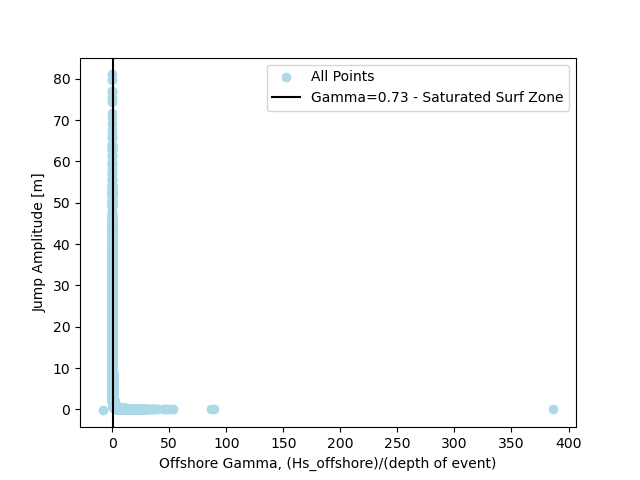

In [67]:
# Compute Offshore Gamma for each jump event
offshore_gamma_all_missions = []
hs_for_each_event = []
for n in range(len(mission_number)):
    hs = mission_df_sorted[mission_df_sorted['mission number'] == mission_number[n]]['Hs [m]'].values[0]
    hs_for_each_event.append(hs * np.ones(len(jump_amps_all_missions[n])))
    offshore_gamma_all_missions.append(hs/jump_amps_all_missions[n])

# Flatten the offshore gamma 
offshore_gamma_all_missions_flat = np.ma.concatenate(offshore_gamma_all_missions).flatten()
hs_for_each_event_flat = np.ma.concatenate(hs_for_each_event).flatten()

fig, ax = plt.subplots()
ax.scatter(offshore_gamma_all_missions_flat, jump_amps_all_missions_flat, color='lightblue', label='All Points')
ax.axvline(0.73, label='Gamma=0.73 - Saturated Surf Zone', color='k')
ax.legend()
ax.set_xlabel('Offshore Gamma, (Hs_offshore)/(depth of event)')
ax.set_ylabel('Jump Amplitude [m]')

In [ ]:
# identify outliers
# Remove all points where depth is 1 meter or less
depth_outlier_inds = np.where(jump_depth_all_missions_flat < 0.25)[0]
# remove jumps less than 0.1 meters
amp_outlier_inds = np.where(jump_amps_all_missions_flat < 0.1)[0]
outlier_inds = np.unique(np.append(depth_outlier_inds, amp_outlier_inds))

fig, ax = plt.subplots()
ax.scatter(offshore_gamma_all_missions_flat, jump_amps_all_missions_flat, color='lightblue', label='All Points')
ax.scatter(offshore_gamma_all_missions_flat[outlier_inds], jump_amps_all_missions_flat[outlier_inds], color='r', label='Outliers')
ax.axvline(0.73, label='Gamma=0.73 - Saturated Surf Zone', color='k')
ax.legend()
ax.set_xlabel('Offshore Gamma, (Hs_offshore)/(depth of event)')
ax.set_ylabel('Jump Amplitude [m]')

In [91]:
# Remove the outlier points
offshore_gamma_all_missions_flat_clean = np.delete(offshore_gamma_all_missions_flat, outlier_inds)
jump_amps_all_missions_flat_clean = np.delete(jump_amps_all_missions_flat, outlier_inds)
hs_for_each_event_flat_clean = np.delete(hs_for_each_event_flat, outlier_inds)
mission_number_for_event_clean = np.delete(np.array(mission_number_for_event), outlier_inds)
trajectory_number_for_event_clean = np.delete(np.array(trajectory_number_for_event), outlier_inds)

Text(0, 0.5, 'Jump Amplitude [m]')

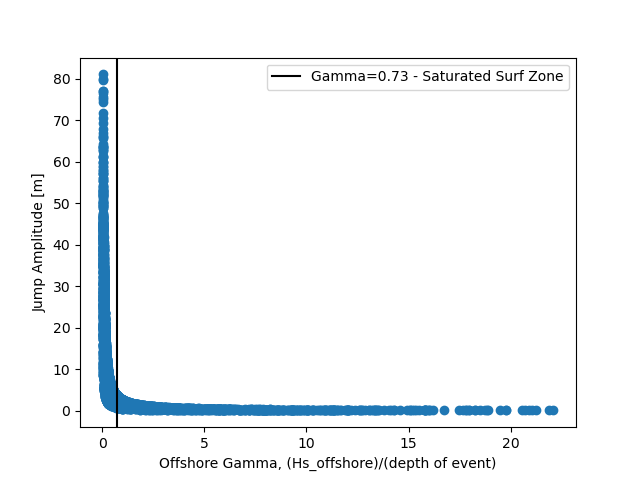

In [62]:
fig, ax = plt.subplots()
ax.scatter(offshore_gamma_all_missions_flat_clean, jump_amps_all_missions_flat_clean)
ax.axvline(0.73, label='Gamma=0.73 - Saturated Surf Zone', color='k')
ax.legend()
ax.set_xlabel('Offshore Gamma, (Hs_offshore)/(depth of event)')
ax.set_ylabel('Jump Amplitude [m]')

Text(0, 0.5, 'Jump Amplitude [m]')

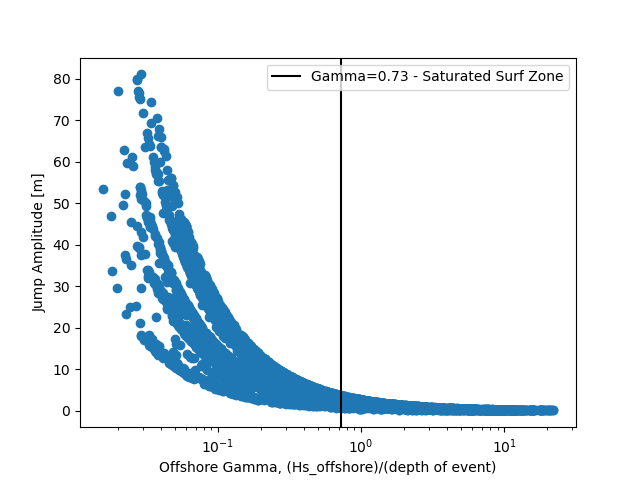

In [63]:
fig, ax = plt.subplots()
ax.scatter(offshore_gamma_all_missions_flat_clean, jump_amps_all_missions_flat_clean)
ax.axvline(0.73, label='Gamma=0.73 - Saturated Surf Zone', color='k')
ax.set_xscale('log')
ax.legend()
ax.set_xlabel('Offshore Gamma, (Hs_offshore)/(depth of event)')
ax.set_ylabel('Jump Amplitude [m]')

Text(0, 0.5, 'Jump Amplitude [m]')

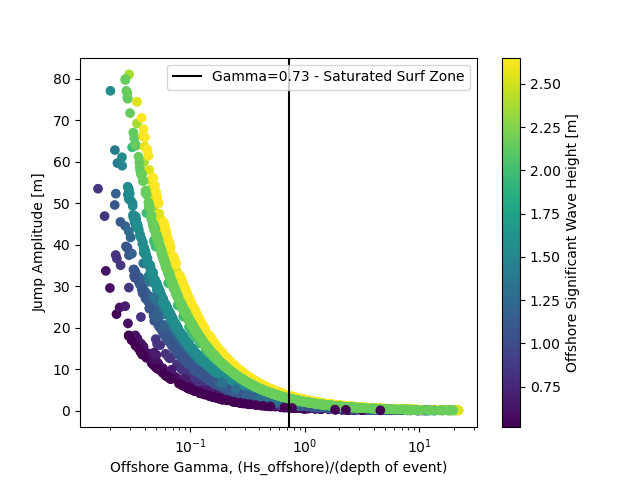

In [66]:
fig, ax = plt.subplots()
im = ax.scatter(offshore_gamma_all_missions_flat_clean, jump_amps_all_missions_flat_clean, c=hs_for_each_event_flat_clean)
cbar = fig.colorbar(im)
cbar.set_label('Offshore Significant Wave Height [m]')
ax.axvline(0.73, label='Gamma=0.73 - Saturated Surf Zone', color='k')
ax.set_xscale('log')
ax.legend()
ax.set_xlabel('Offshore Gamma, (Hs_offshore)/(depth of event)')
ax.set_ylabel('Jump Amplitude [m]')

In [98]:
# Find Mission and Trajectory number for largest jumps
large_jump_inds = np.where(jump_amps_all_missions_flat_clean > 80)[0]
big_jump_mission_num = mission_number_for_event_clean[large_jump_inds][0]
big_jump_trajectory_num = trajectory_number_for_event_clean[large_jump_inds][0]
print(f'Biggest Jump is on Mission {big_jump_mission_num} and trajectory {big_jump_trajectory_num}')

Biggest Jump is on Mission 23 and trajectory 24


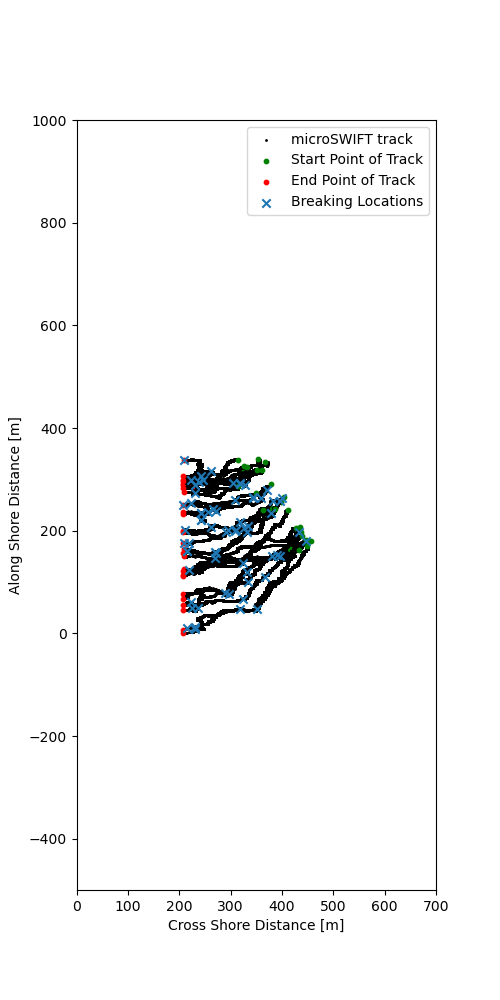

In [106]:
# Load mission 23 data and plot tracks over the radar image
mission_nc_path = '../../microSWIFT_data/final_dataset/mission_23.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Load the breaker dataset
breaker_df = pd.read_csv('../../microSWIFT_data/breaker_df.csv')
breaker_df_mission19 = breaker_df[breaker_df['mission number'] == 23]

# Plot the microSWIFT tracks over the radar image
x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])
vertical_accel = np.ma.masked_invalid(mission_dataset['acceleration_z_body'])
velocity_ew = np.ma.masked_invalid(mission_dataset['velocity_ew'])
time_vals = mission_dataset['time'][:]

fig, ax = plt.subplots(figsize=(5,10))

for n in range(mission_dataset['trajectory'].size-1):
    edge_inds_x = np.ma.flatnotmasked_edges(x_locations[n,:])
    edge_inds_y = np.ma.flatnotmasked_edges(y_locations[n,:])
    start_ind = np.max([edge_inds_x[0], edge_inds_y[0]])
    end_ind = np.min([edge_inds_x[1], edge_inds_y[1]])
    map = ax.scatter(x_locations[n,:],
                        y_locations[n,:],
                        c='k', s=1)
    map = ax.scatter(x_locations[n,start_ind],
                     y_locations[n,start_ind],
                     c='g', s=10)
    map = ax.scatter(x_locations[n,end_ind],
                     y_locations[n,end_ind],
                     c='r', s=10)
    
# plot last track and label points for legend
edge_inds_x = np.ma.flatnotmasked_edges(x_locations[-1,:])
edge_inds_y = np.ma.flatnotmasked_edges(y_locations[-1,:])
start_ind = np.max([edge_inds_x[0], edge_inds_y[0]])
end_ind = np.min([edge_inds_x[1], edge_inds_y[1]])
map = ax.scatter(x_locations[-1,:],
                    y_locations[-1,:],
                    c='k', s=1, label='microSWIFT track')
map = ax.scatter(x_locations[-1,start_ind],
                    y_locations[-1,start_ind],
                    c='g', s=10, label='Start Point of Track')
map = ax.scatter(x_locations[-1,end_ind],
                    y_locations[-1,end_ind],
                    c='r', s=10, label='End Point of Track')

# Scatter all Detected Breaking locations from the mission
ax.scatter(breaker_df_mission19['cross shore location [m]'], breaker_df_mission19['along shore location [m]'], 
           marker='x', label='Breaking Locations')

ax.set_xlim(0, 700)
ax.set_ylim(-500, 1000)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Along Shore Distance [m]')
ax.legend()
ax.set_aspect('equal')

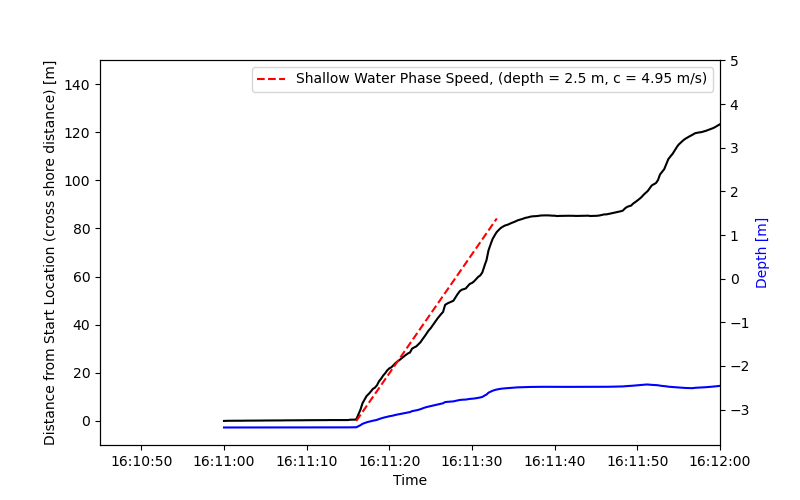

In [128]:
# Further Explore the big jump mission
mission_nc_path = '../../microSWIFT_data/final_dataset/mission_23.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Plot the microSWIFT tracks over the radar image
x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])
vertical_accel = np.ma.masked_invalid(mission_dataset['acceleration_z_body'])
velocity_ew = np.ma.masked_invalid(mission_dataset['velocity_ew'])
time_vals = mission_dataset['time'][:]

trajectory_num = 24
time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)
cross_shore_vel = np.gradient((x_locations[trajectory_num,0] - x_locations[trajectory_num,:]), 1/12)
cross_shore_vel = np.ma.filled(cross_shore_vel, np.NaN)
sos = signal.butter(1, 0.1, 'lowpass', fs=12, output='sos')
cross_shore_vel_filtered = signal.sosfilt(sos, cross_shore_vel)

# Depth Along Trajectory
tracjectory_bathy = mission_tools.bathy_along_track(bathy_file='../../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc', 
                                                    xFRF=x_locations[trajectory_num, :], 
                                                    yFRF=y_locations[trajectory_num, :],
                                                    single_trajectory=True)

# Compute Linear Phase Speed at each point in track
phase_speed_along_track = np.sqrt(np.abs(tracjectory_bathy * 9.8))[0]

# phase speed for breaking
water_level =  mission_df_sorted[mission_df_sorted['mission number'] == 23]['water level [m]'].values[0]
breaking_depth = 2.5 # found from looking at plot 
c_breaking = np.sqrt(9.8 * np.abs(breaking_depth)) 
seconds_phase_speed = np.linspace(0, 17, 15)
distance_traveled_at_phase_speed = (c_breaking * seconds_phase_speed) # offset for fitting to the plot
t = pd.date_range(start='2021-10-10T16:11:16',
                  end='2021-10-10T16:11:33',
                  periods=15)

fig, ax1 = plt.subplots(figsize=(8,5))

# Cross Shore Distance
ax1.plot(time, x_locations[trajectory_num,0] - x_locations[trajectory_num,:], color='k')
ax1.set_xlabel('Time')
ax1.set_ylabel('Distance from Start Location (cross shore distance) [m]', color='k')
ax1.plot(t.values, distance_traveled_at_phase_speed, color='r', linestyle='dashed', 
         label=f'Shallow Water Phase Speed, (depth = {np.round(np.abs(breaking_depth), 2)} m, c = {np.round(c_breaking, 2)} m/s)')
ax2 = ax1.twinx()
ax2.plot(time, tracjectory_bathy[0]+water_level, color='blue')
ax2.set_ylabel('Depth [m]', color='blue')
ax1.set_xlim(datetime(2021, 10, 10, 16, 10, 45), datetime(2021, 10, 10, 16, 12, 0))
ax1.set_ylim(-10, 150)
ax1.legend()
